In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
file_path = '/content/0131799991.csv'  # Update with your file path if needed
data = pd.read_csv(file_path)

# Drop columns with too many missing values (threshold = 50% missing)
data_cleaned = data.dropna(axis=1, thresh=int(0.5 * len(data)))

# Drop any remaining rows with missing values
data_cleaned = data_cleaned.dropna()

# Normalize the numeric columns (excluding 'time' and 'cadenceno')
scaler = MinMaxScaler()
numeric_cols = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = numeric_cols.drop(['time', 'cadenceno'], errors='ignore')

data_cleaned[numeric_cols] = scaler.fit_transform(data_cleaned[numeric_cols])

# Display cleaned and normalized dataset
print(data_cleaned.head())

# Save the cleaned dataset to a new CSV file
data_cleaned.to_csv('/content/cleaned_tess_data.csv', index=False)
print("\nCleaned and normalized dataset saved to 'cleaned_tess_data.csv'")

            time      flux  flux_err  timecorr  cadenceno  centroid_col  \
338  1517.847352  0.054195  0.997072  0.971368     209080      0.507797   
339  1517.848741  0.083335  1.000000  0.971390     209081      0.505683   
340  1517.850130  0.080499  0.986552  0.971412     209082      0.496994   
341  1517.851519  0.067746  0.978062  0.971433     209083      0.503946   
342  1517.852908  0.075420  0.974297  0.971455     209084      0.528088   

     centroid_row  sap_flux  sap_flux_err   sap_bkg  sap_bkg_err  pdcsap_flux  \
338      0.133961  0.093222      0.997074  1.000000     1.000000     0.054195   
339      0.148050  0.124814      1.000000  0.984614     0.988433     0.083335   
340      0.119483  0.124944      0.986553  0.982086     0.983210     0.080499   
341      0.105550  0.106478      0.978063  0.970009     0.974139     0.067746   
342      0.184401  0.121557      0.974297  0.969468     0.976091     0.075420   

     pdcsap_flux_err  quality  mom_centr1  mom_centr1_err  mom

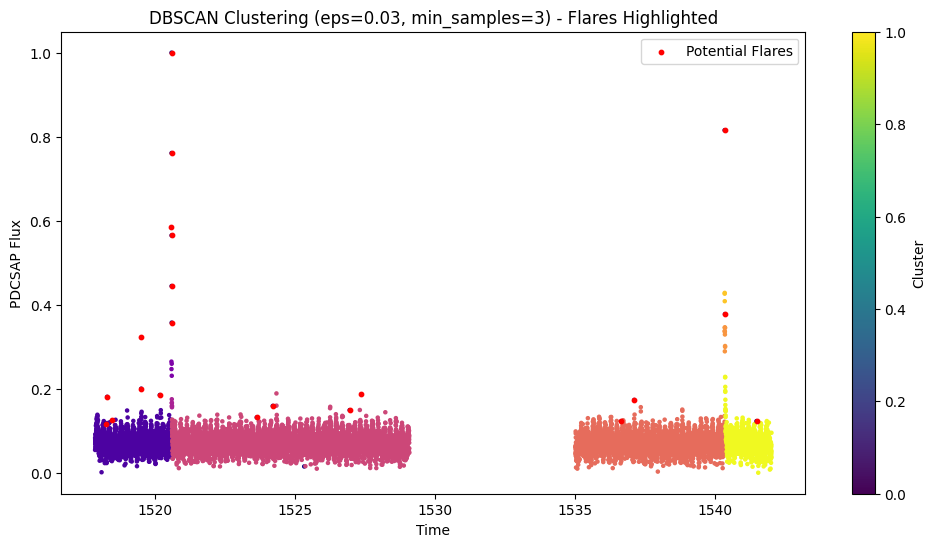

Number of potential flare events detected (using PDCSAP_FLUX): 21


In [ ]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Fine-tune DBSCAN for flare detection using PDCSAP_FLUX
eps = 0.03  # Smaller neighborhood size
min_samples = 3  # Lower to detect short events

# Fit DBSCAN using PDCSAP_FLUX
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
data_cleaned['cluster'] = dbscan.fit_predict(data_cleaned[['time', 'pdcsap_flux']])

# Separate noise points (potential flares)
flares = data_cleaned[data_cleaned['cluster'] == -1]

# Filter flares using a flux threshold
flare_threshold = 0.1  # Adjust as needed to filter out low-level noise
flares = flares[flares['pdcsap_flux'] > flare_threshold]

# Plot clusters using PDCSAP_FLUX
plt.figure(figsize=(12, 6))
plt.scatter(data_cleaned['time'], data_cleaned['pdcsap_flux'], c=data_cleaned['cluster'], cmap='plasma', s=5)
plt.scatter(flares['time'], flares['pdcsap_flux'], color='red', label='Potential Flares', s=10)
plt.title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples}) - Flares Highlighted')
plt.xlabel('Time')
plt.ylabel('PDCSAP Flux')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()

# Check how many flare candidates were identified
print(f"Number of potential flare events detected (using PDCSAP_FLUX): {len(flares)}")

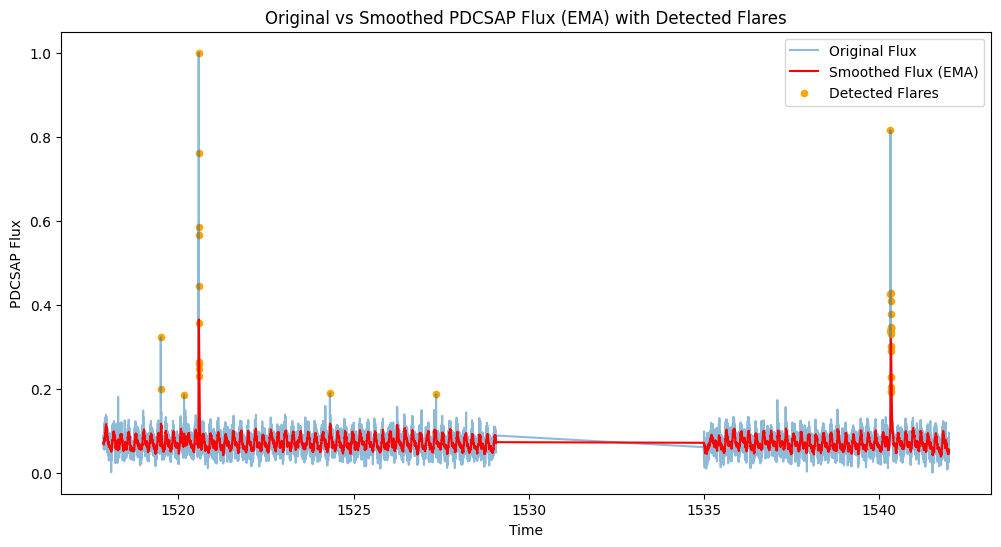

Number of potential flare events detected (using EMA and DBSCAN): 34
Detected flares saved to 'detected_flares_tuned.csv'


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.cluster import DBSCAN

# Load the cleaned dataset
file_path = 'cleaned_tess_data.csv'
data_cleaned = pd.read_csv(file_path)

# Apply Exponential Moving Average (EMA) for smoothing
# Lower span for more responsiveness, higher for smoother signal
data_cleaned['ema_flux'] = data_cleaned['pdcsap_flux'].ewm(span=15, adjust=False).mean()

# Generate additional features
data_cleaned['flux_gradient'] = data_cleaned['pdcsap_flux'].diff()
data_cleaned['flux_variance'] = data_cleaned['pdcsap_flux'].rolling(window=10).var()
data_cleaned['flux_skew'] = data_cleaned['pdcsap_flux'].rolling(window=10).apply(skew, raw=True)
data_cleaned['flux_kurtosis'] = data_cleaned['pdcsap_flux'].rolling(window=10).apply(kurtosis, raw=True)
data_cleaned['flux_zscore'] = (data_cleaned['pdcsap_flux'] - data_cleaned['pdcsap_flux'].mean()) / data_cleaned['pdcsap_flux'].std()

# Add Rolling Count for Temporal Context
# Count the number of spikes within a rolling window to identify flaring activity clusters
data_cleaned['rolling_count'] = (data_cleaned['flux_zscore'] > 2).rolling(window=10).sum()

# Drop rows with missing values due to rolling windows
data_cleaned = data_cleaned.dropna()

# Improved Flare Detection Using DBSCAN
# Fine-tuned DBSCAN parameters
features = ['ema_flux', 'flux_gradient', 'flux_variance', 'flux_skew', 'flux_kurtosis', 'flux_zscore', 'rolling_count']
dbscan = DBSCAN(eps=0.5, min_samples=3)   # Increased eps, lowered min_samples
data_cleaned['cluster'] = dbscan.fit_predict(data_cleaned[features])

# Filter potential flares using a higher z-score threshold to reduce false positives
flare_threshold = data_cleaned['flux_zscore'].mean() + 4 * data_cleaned['flux_zscore'].std()
flares = data_cleaned[(data_cleaned['cluster'] == -1) & (data_cleaned['flux_zscore'] > flare_threshold)]

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(data_cleaned['time'], data_cleaned['pdcsap_flux'], label='Original Flux', alpha=0.5)
plt.plot(data_cleaned['time'], data_cleaned['ema_flux'], label='Smoothed Flux (EMA)', color='red')
plt.scatter(flares['time'], flares['pdcsap_flux'], color='orange', label='Detected Flares', s=20)
plt.title('Original vs Smoothed PDCSAP Flux (EMA) with Detected Flares')
plt.xlabel('Time')
plt.ylabel('PDCSAP Flux')
plt.legend()
plt.show()

# Check how many flare candidates were identified
print(f"Number of potential flare events detected (using EMA and DBSCAN): {len(flares)}")

# Save detected flares to a new file
flares.to_csv('detected_flares_tuned.csv', index=False)
print("Detected flares saved to 'detected_flares_tuned.csv'")